# CERN & Particle physics: Discrimination of positron/photon/pion showers in EM calorimeter

### Step 1: Frame the problem
Datasett link: https://zenodo.org/record/573298#.Y-n-mXaZNtZ
Given the hdf5 file that have a following structure:
energy    Dataset {100000, 1}
layer_0   Dataset {100000, 3, 96}
layer_1   Dataset {100000, 12, 12}
layer_2   Dataset {100000, 12, 6}
overflow  Dataset {100000, 3}
In practice, each file is a collection of 100,000 calorimeter showers corresponding to the particle specified in the file name (eplus = positrons, gamma = photons, piplus = charged pions).

The calorimeter we built is segmented longitudinally into three layer with different depths and granularities. In units of mm, the three layers have the following (eta, phi, z) dimensions:
Layer 0: (5, 160, 90) | Layer 1: (40, 40, 347) | Layer 2: (80, 40, 43)

In the HDF5 files, the `energy` entry specifies the true energy of the incoming particle in units of GeV. `layer_0`, `layer_1`, and `layer_2` represents the energy deposited in each layer of the calorimeter in an image data format. Given the segmentation of each calorimeter layer, these images have dimensions 3x96 (in layer 0), 12x12 (in layer 1), and 12x6 (in layer 3). The `overflow` contains the amount of energy that was deposited outside of the calorimeter section we are considering.

Train classifier based on image recognition. Utilize 3D information.
Convert data arrays into suitable image format. Train CNN. Each event consist of three data/image layers - investigate how this can be treated. 

### Step 2: Set up enviroment, import data

Import necessary libraries

In [76]:
import numpy as np
import h5py

#Change to fastai?
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import Sequential
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [77]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [78]:
# Code below can show waht are different columns existing in one hdf5 file
filename = "eplus.hdf5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['energy', 'layer_0', 'layer_1', 'layer_2', 'overflow']>
<class 'h5py._hl.dataset.Dataset'>


In [79]:
d_gamma = h5py.File('gamma.hdf5', 'r') # 'r' is jsut to specify that input of file is string name
d_eplus = h5py.File('eplus.hdf5', 'r')
d_piplus = h5py.File('piplus.hdf5', 'r')

In [80]:
gamma_0 = d_gamma['layer_0'][:]
gamma_1 = d_gamma['layer_1'][:]
gamma_2 = d_gamma['layer_2'][:]

eplus_0 = d_eplus['layer_0'][:]
eplus_1 = d_eplus['layer_1'][:]
eplus_2 = d_eplus['layer_2'][:]

piplus_0 = d_piplus['layer_0'][:]
piplus_1 = d_piplus['layer_1'][:]
piplus_2 = d_piplus['layer_2'][:]

In [81]:
real_images_gamma = [gamma_0, gamma_1, gamma_2]
real_images_eplus = [eplus_0, eplus_1, eplus_2]
real_images_piplus = [piplus_0, piplus_1, piplus_2]

Because og the heterogenous segmentation in eta and phi of each layer of the detector, the images we use to represent the energy deposits in each layer will have different sizes. For convenience later on, we save those sizes in a list.

In [82]:
sizes = [
    gamma_0.shape[1], gamma_0.shape[2],
    gamma_1.shape[1], gamma_1.shape[2],
    gamma_2.shape[1], gamma_2.shape[2],
]
print(sizes)

[3, 96, 12, 12, 12, 6]


Now we will plot first photon shower to see how these images actually look like

In [83]:
from matplotlib.colors import LogNorm

def plot_image(image, layer, vmin=None, vmax=None):
    '''
    Args:
    -----
        image: ndarray with energies collected by each calo cell
        layer: int in {0,1,2}, useful to resize image correctly
        vmin: float, min energy to clip at
        vmax: float, max energy to clip at
    '''
    fig = plt.figure(figsize=(20,20))
    im = plt.imshow(image,
               aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest',
               norm=LogNorm(vmin, vmax)
    )
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params()
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])
    if layer == 0:
        xticks = xticks[::10]
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID')
    plt.ylabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    return im

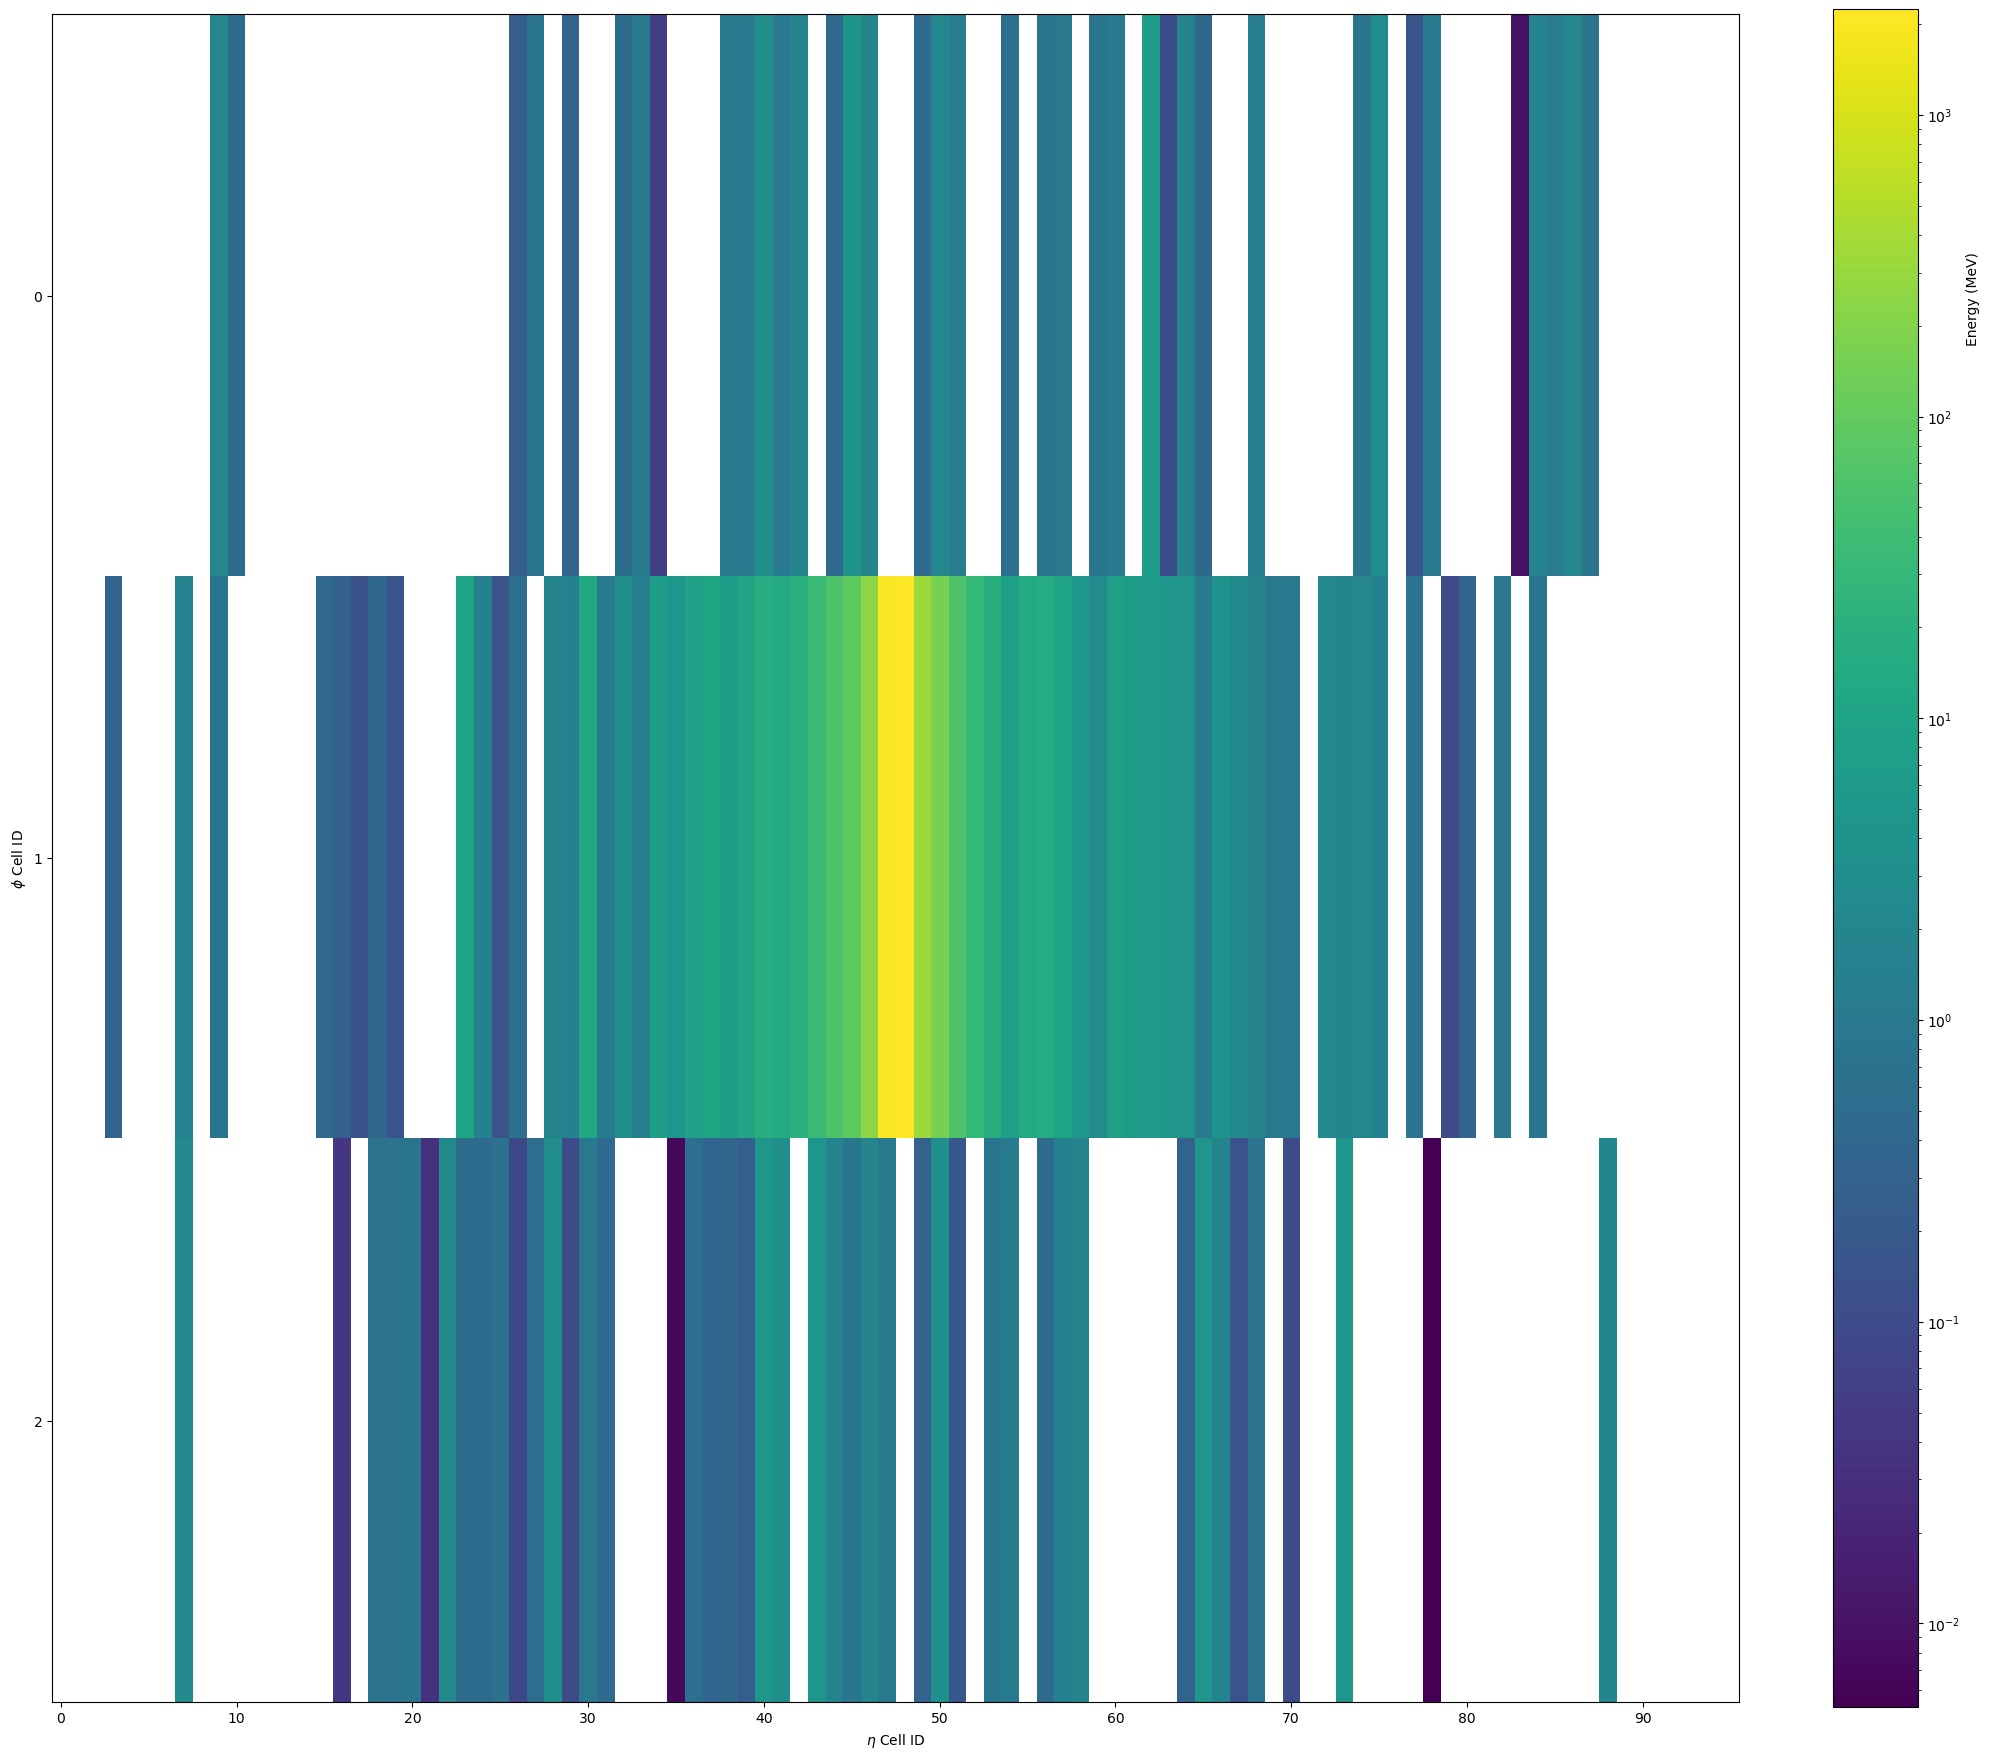

In [84]:
imageix = 0 # let's look at the very first shower
plot_image(gamma_0[imageix], layer=0)

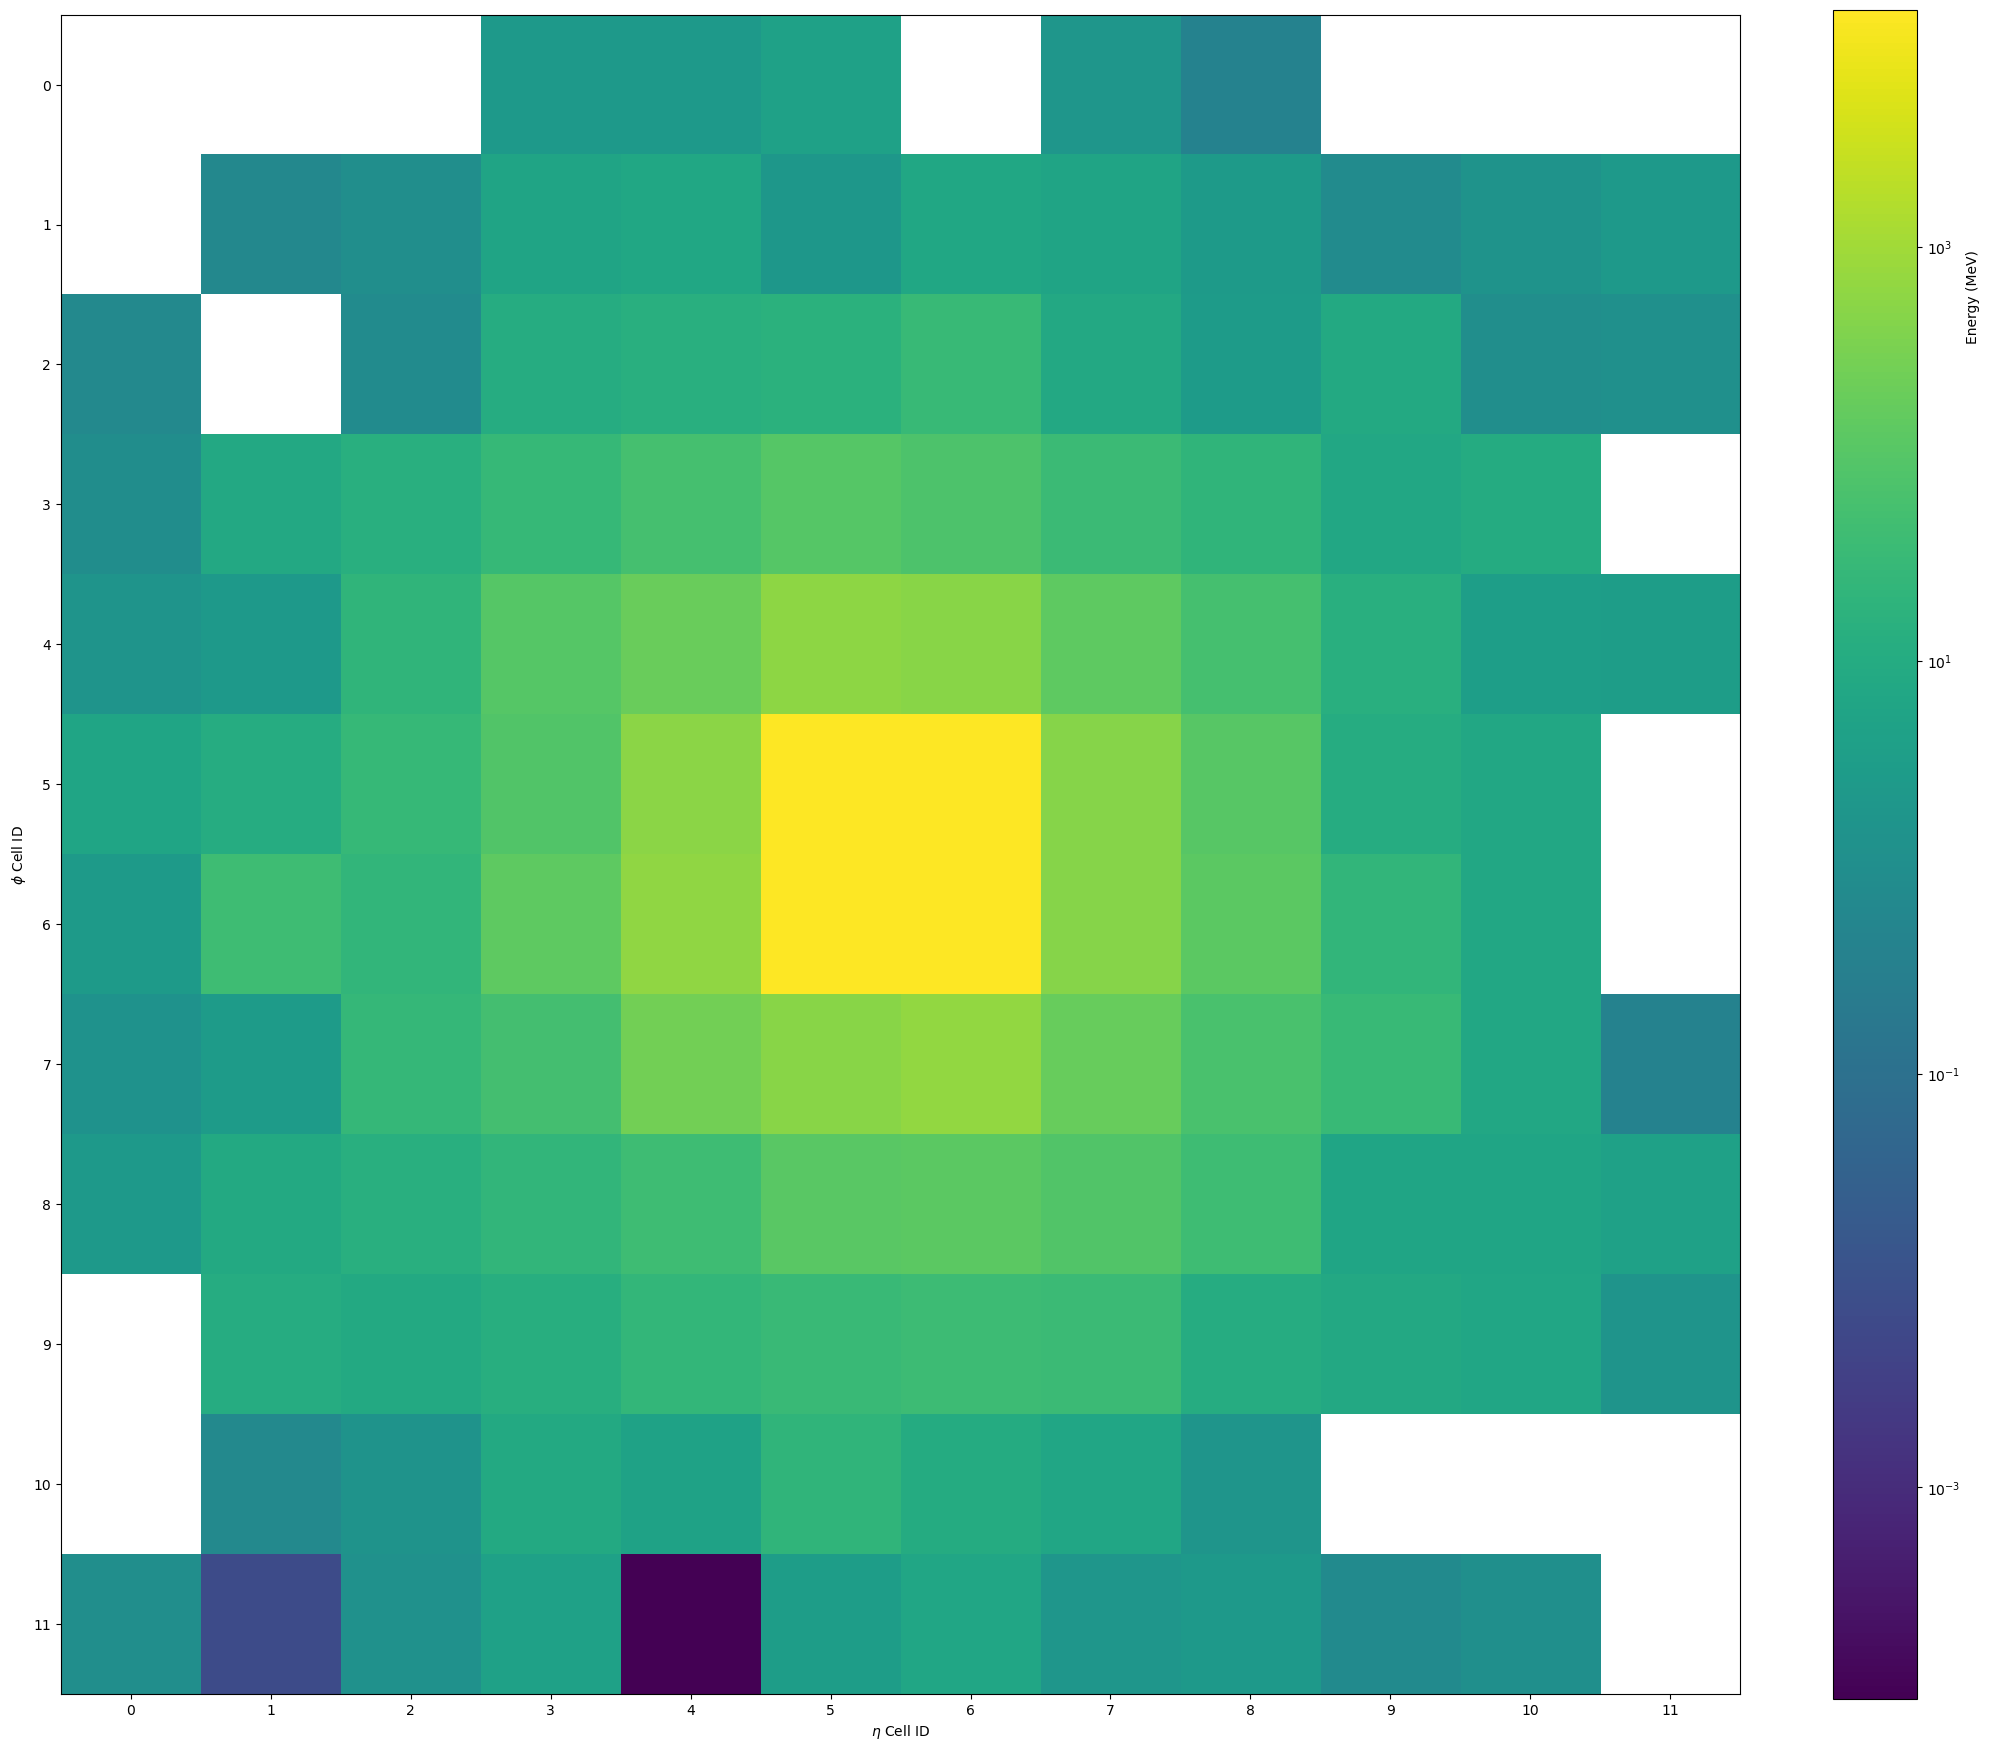

In [85]:
im = plot_image(gamma_1[imageix], layer=1)

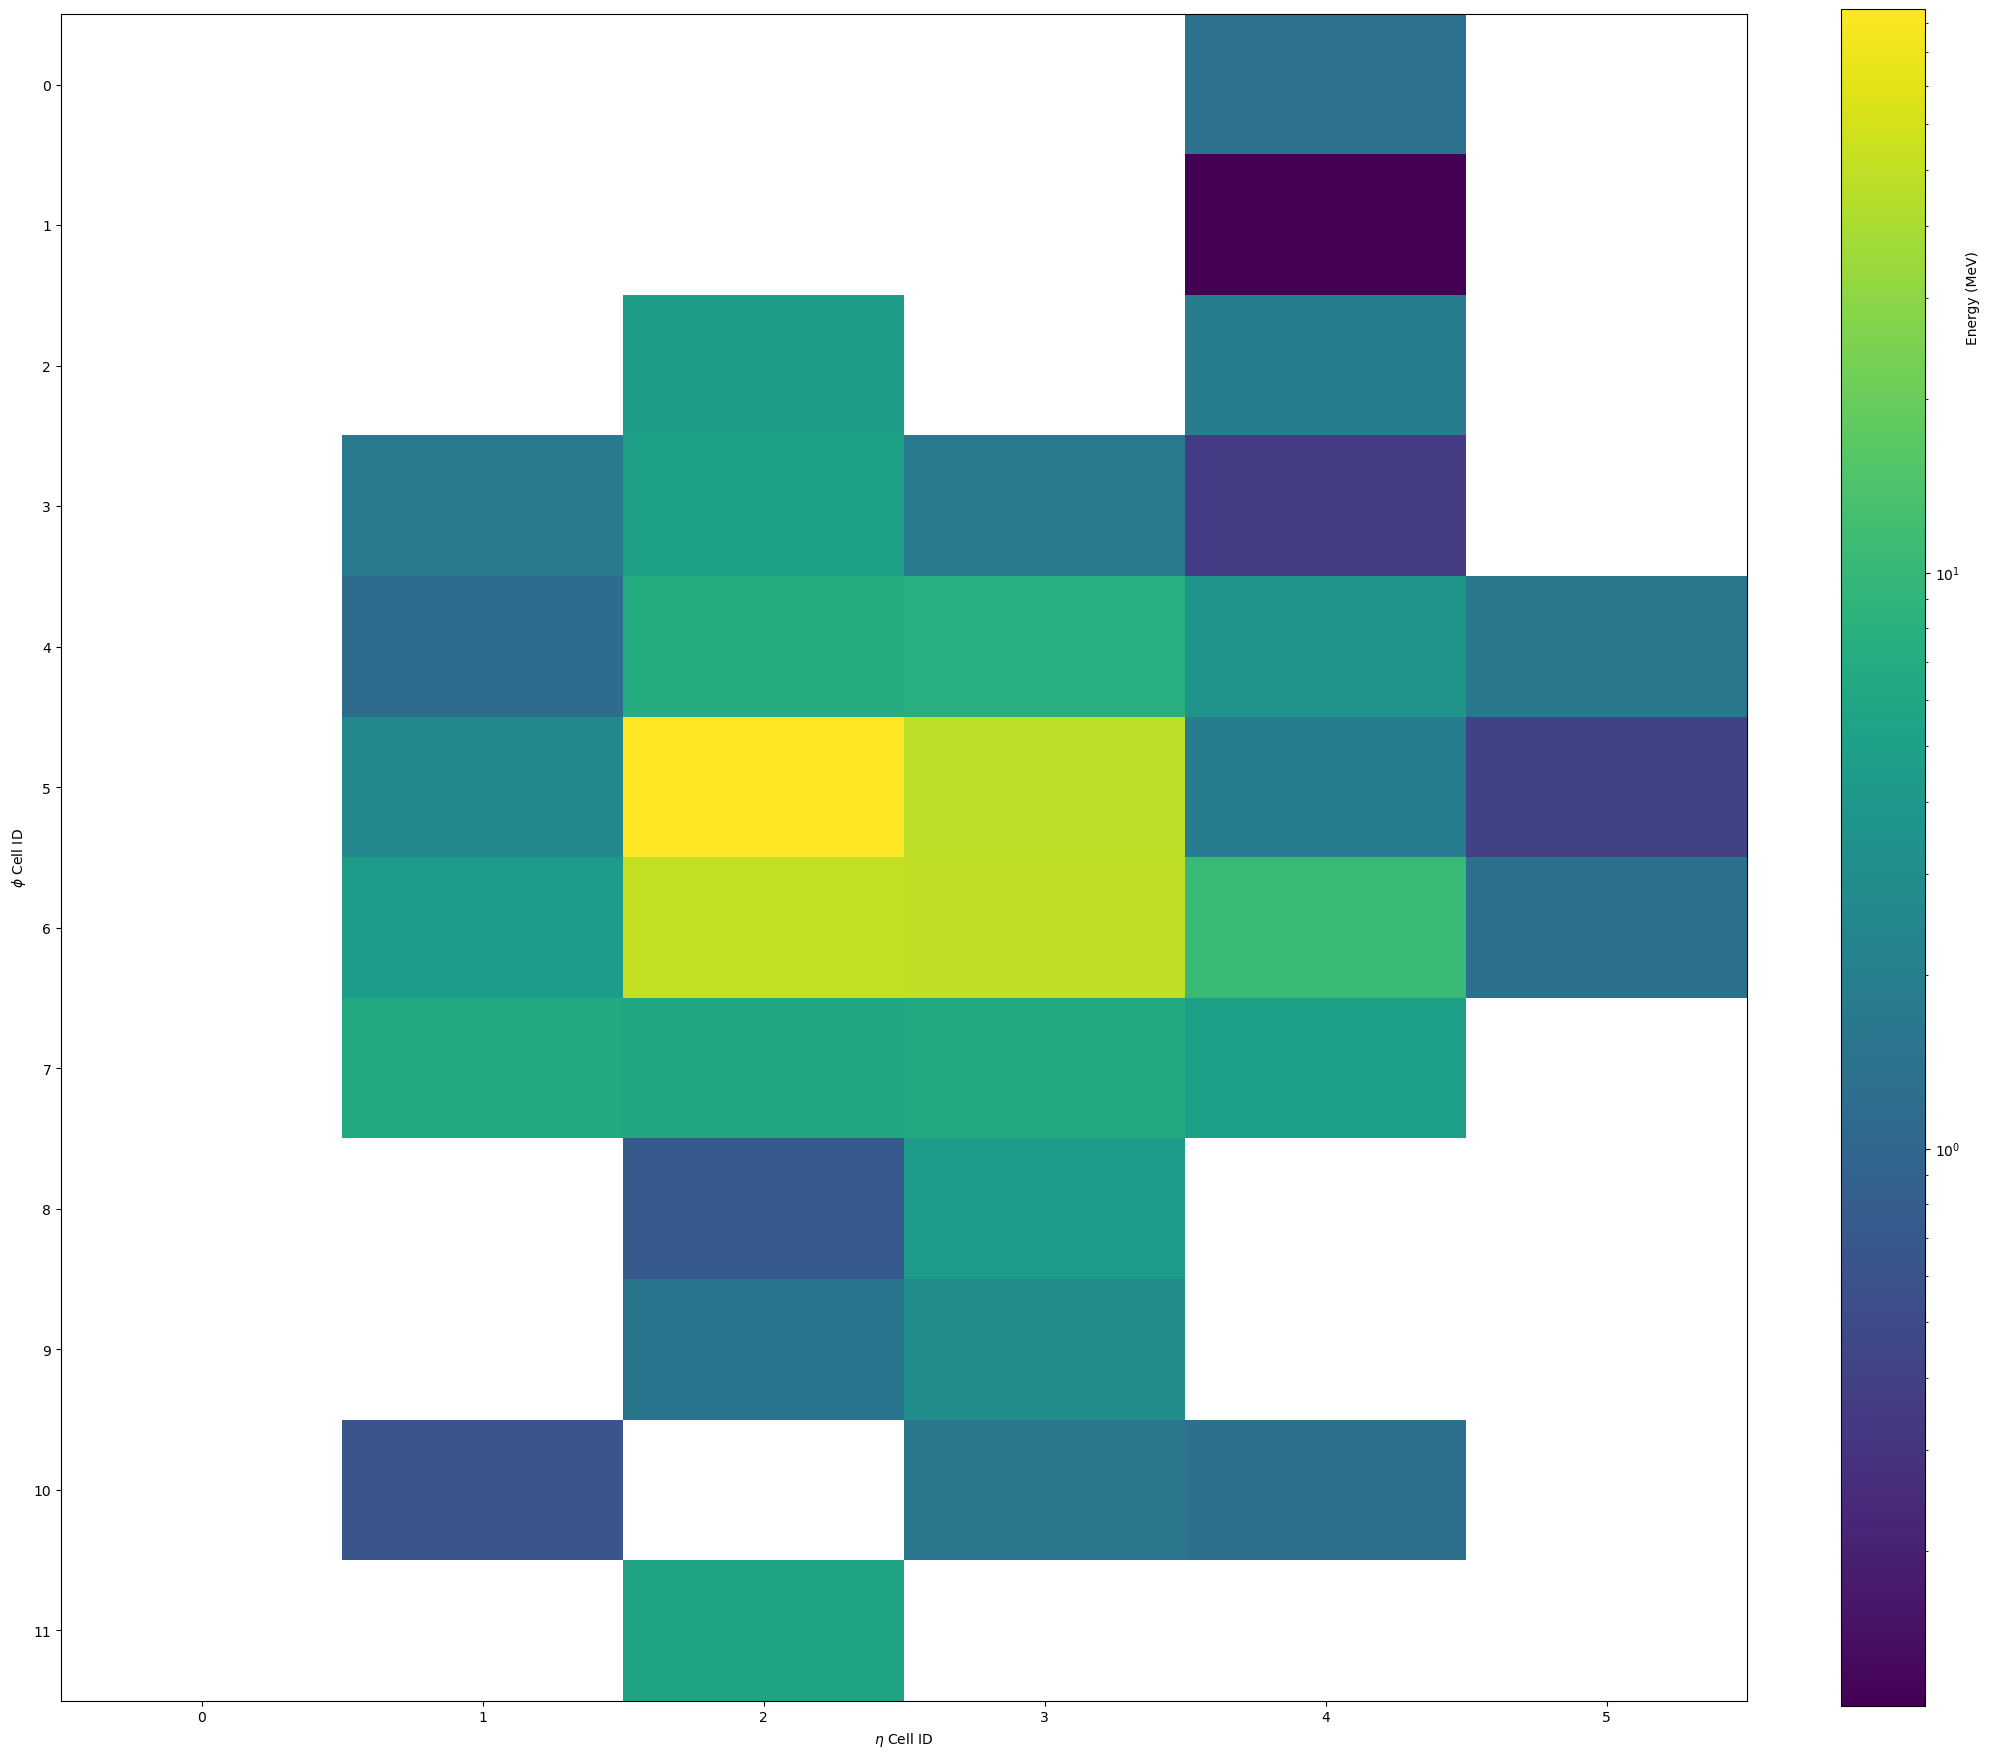

In [86]:
plot_image(gamma_2[imageix], layer=2)

The architecture consists of the following components:
- Input Layer: It takes an image of shape (...) as input
- Convolutional Layers: A set of Convolutional Layers are used to extract features from the input image. The convolutional Layer applies filters (weights) to the input image and performs element-wise multiplications and sums to produce an activation map
- Max Pooling Layers: After each Convolutional Layer, a Max Pooling Layer is used to reduce the size of the activation map, thus reducing the number of parameters in the model. Max Pooling Layers perform a down-sampling operation by selecting the maximum value from a set of values in a pooling window
- Droput Layers: Droput Layers are used to prevent overfitting of the model. It works by randomly setting a portion of the inputs to zero durin each training iteration.
- Flatten Layer: The Flatten Layer converts the 3D feature map into a 1D vector, which can be fed into hte fully connected layer
- Dense Layer: The Dense Layer is a fully connected layer that performs classification based on the features extracted by the Convolutional Layers
- Output Layer: The Output Layer produces the final classification result by applying a sfotmax activation function to the outputs of the Dense Layer

### Step 3: Load data, preprocess and train

In this section i combined all steps in one elegant main class with functions, only thign needed here to train data on different files is to change file name in init main

In [90]:
#load data
def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        energy = f['energy'][:]
        layer_0 = f['layer_0'][:]
        layer_1 = f['layer_1'][:]
        layer_2 = f['layer_2'][:]
        overflow = f['overflow'][:]
    return energy, layer_0, layer_1, layer_2, overflow

#preprocess
def preprocess_data(energy, layer_0, layer_1, layer_2, overflow):
    layer_0_resized = np.array([resize(layer_0[i], (12, 12)) for i in range(layer_0.shape[0])])
    layer_2_resized = np.array([resize(layer_2[i], (12, 12)) for i in range(layer_2.shape[0])])
    
    data = np.concatenate([layer_0_resized[..., np.newaxis],
                           layer_1[..., np.newaxis],
                           layer_2_resized[..., np.newaxis]], axis=-1)
    data = (data - np.mean(data)) / np.std(data)
    return data, energy


# Split the data into training, validation, and test sets
def train_cnn(data, energy):
    # Split the data into training, validation, and test sets
    train_data = data[:70000]
    train_labels = energy[:70000]
    val_data = data[70000:80000]
    val_labels = energy[70000:80000]
    test_data = data[80000:]
    test_labels = energy[80000:]    
    # Convert the labels to categorical format
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_data.shape[1:]))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(train_labels.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels))
    tes_loss, test_acc = model.evaluate(test_data, test_labels)

    print('Test accuracy:', test_acc)

if __name__ == '__main__':
    energy, layer_0, layer_1, layer_2, overflow = load_data("gamma.hdf5")
    data, energy = preprocess_data(energy, layer_0, layer_1, layer_2, overflow)
    train_cnn(data, energy)

Epoch 1/10
2188/2188 [==============================] - 8s 4ms/step - loss: 2.1983 - accuracy: 0.2586 - val_loss: 1.5710 - val_accuracy: 0.3731
Epoch 2/10
2188/2188 [==============================] - 8s 3ms/step - loss: 1.4154 - accuracy: 0.4321 - val_loss: 1.3071 - val_accuracy: 0.4876
Epoch 3/10
2188/2188 [==============================] - 7s 3ms/step - loss: 1.2103 - accuracy: 0.4997 - val_loss: 1.0371 - val_accuracy: 0.5888
Epoch 4/10
2188/2188 [==============================] - 8s 3ms/step - loss: 1.0978 - accuracy: 0.5433 - val_loss: 1.0098 - val_accuracy: 0.5929
Epoch 5/10
2188/2188 [==============================] - 7s 3ms/step - loss: 1.0255 - accuracy: 0.5694 - val_loss: 0.9831 - val_accuracy: 0.5843
Epoch 6/10
2188/2188 [==============================] - 8s 4ms/step - loss: 0.9781 - accuracy: 0.5893 - val_loss: 0.8997 - val_accuracy: 0.6268
Epoch 7/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.9432 - accuracy: 0.6039 - val_loss: 0.9708 - val_accuracy:

In the code above, we first define the architecture using the 'Sequential' model class. Then, we add a series of layers to the model using the 'add' method.
The first layer is a 2D Convolutional layer with 32 filters, a kernel size of '(3, 3)', and a ReLu activation function. The 'input_shape' parameter specifies the shape of the input data. In this case, it is taken from the shape of 'train_data', which is '(70000, 12, 12, 3)'. 
The second layer is also a 2D Convolutional layer with 64 filters, a kernel size of (3, 3), and a ReLU activation function.
The third layer is a Flatten layer, which flattens the output of the previous layer into a 1D tensor, so that it can be used as input for the next layer.
The fourth layer is a Dense layer with 128 units and a ReLU activation function.
The final layer is a Dense layer with train_labels.shape[1] units and a softmax activation function, since the labels are categorical in nature. This layer will output the predicted probabilities for each class.

We try to do the same as in previous block but now training on 3D model to see if there wil be difference in accuracy

In [88]:
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

In [92]:
#load data
def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        energy = f['energy'][:]
        layer_0 = f['layer_0'][:]
        layer_1 = f['layer_1'][:]
        layer_2 = f['layer_2'][:]
        overflow = f['overflow'][:]
    return energy, layer_0, layer_1, layer_2, overflow

#preprocess
def preprocess_data(energy, layer_0, layer_1, layer_2, overflow):
    layer_0_resized = np.array([resize(layer_0[i], (12, 12)) for i in range(layer_0.shape[0])])
    layer_2_resized = np.array([resize(layer_2[i], (12, 12)) for i in range(layer_2.shape[0])])
    
    data = np.concatenate([layer_0_resized[..., np.newaxis],
                           layer_1[..., np.newaxis],
                           layer_2_resized[..., np.newaxis]], axis=-1)
    data = (data - np.mean(data)) / np.std(data)
    return data, energy


# Split the data into training, validation, and test sets
def train_cnn(data, energy):
    # Split the data into training, validation, and test sets
    train_data = data[:70000]
    train_labels = energy[:70000]
    val_data = data[70000:80000]
    val_labels = energy[70000:80000]
    test_data = data[80000:]
    test_labels = energy[80000:]    
    # Convert the labels to categorical format
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)
    
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), activation='relu', padding='same', input_shape=(12, 12, 3, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))
    model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(train_labels.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels))
    test_loss, test_acc = model.evaluate(test_data, test_labels)
    
    print('Test accuracy:', test_acc)

if __name__ == '__main__':
    energy, layer_0, layer_1, layer_2, overflow = load_data("gamma.hdf5")
    data, energy = preprocess_data(energy, layer_0, layer_1, layer_2, overflow)
    train_cnn(data, energy)

Epoch 1/10
2188/2188 [==============================] - 21s 10ms/step - loss: 2.3814 - accuracy: 0.2129 - val_loss: 1.6783 - val_accuracy: 0.3579
Epoch 2/10
2188/2188 [==============================] - 20s 9ms/step - loss: 1.5328 - accuracy: 0.3828 - val_loss: 1.5130 - val_accuracy: 0.3742
Epoch 3/10
2188/2188 [==============================] - 21s 9ms/step - loss: 1.3161 - accuracy: 0.4509 - val_loss: 1.2744 - val_accuracy: 0.4847
Epoch 4/10
2188/2188 [==============================] - 21s 10ms/step - loss: 1.1857 - accuracy: 0.4987 - val_loss: 1.3446 - val_accuracy: 0.4336
Epoch 5/10
2188/2188 [==============================] - 21s 10ms/step - loss: 1.1200 - accuracy: 0.5251 - val_loss: 1.0745 - val_accuracy: 0.5198
Epoch 6/10
2188/2188 [==============================] - 21s 10ms/step - loss: 1.0626 - accuracy: 0.5485 - val_loss: 0.9910 - val_accuracy: 0.5875
Epoch 7/10
2188/2188 [==============================] - 21s 10ms/step - loss: 1.0123 - accuracy: 0.5702 - val_loss: 0.8706 - v